
# Filtering and pre-processing

Given the AnnData matrix created in the previous step, run some filtering and tooling steps for later processes.

In [1]:
import os
import collections

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
%matplotlib inline

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

/home/ubuntu/.local/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4 anndata==0.6.19 numpy==1.17.0 scipy==1.2.1 pandas==0.25.0 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


Load the AnnData matrix previously created. We have duplicate gene names in this matrix because of the merge step. We will only keep one of them.

In [2]:
adata = anndata.read_h5ad(os.path.join("write", "merged-final.h5ad"))

In [3]:
adata.var["gene_names"] = adata.var["gene_names-control"]
del adata.var["gene_names-control"]
del adata.var["gene_names-treated"]

In [4]:
adata

AnnData object with n_obs × n_vars = 25376 × 27798 
    obs: 'batch', 'cellular_barcode'
    var: 'gene_names'
    layers: 'ambiguous', 'spliced', 'unspliced'

## Filtering cells not present in Cellranger output

Cellranger does some extra filtering steps after the `.bam` files are generated. We have the list of barcodes that are present in the matrix produced by Cellranger. Anything not in that list will be removed from this analysis.

In [5]:
def add_cellranger_barcodes_to_set(batch, set_name):
    with open("source/{}_cellranger.cells.tsv".format(batch), 'r') as f:
        for cell in f:
            cell = cell.strip()
            set_name.add("{}-{}".format(cell, batch))

In [6]:
cellranger_barcodes = set()

for batch in ('control', 'treated'):
    add_cellranger_barcodes_to_set(batch, cellranger_barcodes)

In [7]:
len(cellranger_barcodes)

13634

In [8]:
adata.obs.index.isin(cellranger_barcodes)

array([False, False, False, ...,  True,  True,  True])

In [9]:
adata = adata[adata.obs.index.isin(cellranger_barcodes)]

## Identifying total count

From this data set, we will compute the total number of RNA molecules found in each cell.

In [10]:
adata.obs['n_counts'] = np.ravel(adata.X.sum(axis=1))

In [11]:
adata.obs['n_counts']

index
TTAGTTCGTCGCATAT-1-control       634.0
ACCGTAATCCCAACGG-1-control       938.0
TATTACCCAATGGTCT-1-control       725.0
GGACAGACAGGCTCAC-1-control      1285.0
ACCCACTGTTCGGGCT-1-control       734.0
                                ...   
CCGTTCAAGGATGTAT-1-treated    133317.0
TCGCGAGGTAAGAGGA-1-treated    119114.0
TTCTCAATCTGATTCT-1-treated    109842.0
TGGTTAGTCGGCATCG-1-treated    115940.0
CGAGAAGCAGCCAATT-1-treated    129951.0
Name: n_counts, Length: 13632, dtype: float32

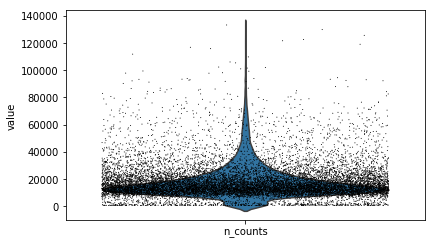

In [12]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

In [13]:
adata

AnnData object with n_obs × n_vars = 13632 × 27798 
    obs: 'batch', 'cellular_barcode', 'n_counts'
    var: 'gene_names'
    layers: 'ambiguous', 'spliced', 'unspliced'

## Visualizing most expressed genes

Create a plot showing the genes that are found the most across our data set.

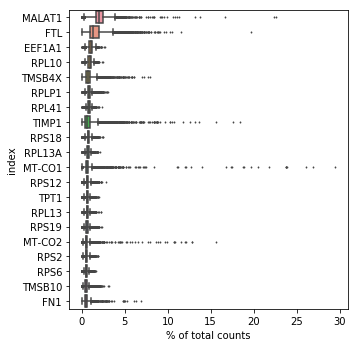

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

## Filtering by gene and cell count

We will now we filter out cells that have fewer than a certain number expressed genes.

In [15]:
sc.pp.filter_cells(adata, min_genes=2000)

filtered out 734 cells that have less than 2000 genes expressed


We now filter out genes that are expressed in fewer than a certain number of cells. Before doing so, we want to save a version of the complete list of genes for future analysis.

In [16]:
original_genes = list(adata.var["gene_names"])
sc.pp.filter_genes(adata, min_cells=100)

filtered out 11634 genes that are detected in less than 100 cells


After this step, we have gotten additional information, including `n_genes`, automatically computing the number of genes found to be expressed in each cell.

## Identifying ratio of mitochondrial genes

We want to compute a ratio of mitochondrial genes to total count for each cell. This is important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [17]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.ravel(np.sum(
    adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(adata.X, axis=1))

Get number of mito genes in our gene set.

In [18]:
len([i for i in mito_genes if i])

13

Get number of mito gene counts per cell.

In [19]:
np.sum(adata[:, mito_genes].X, axis=1)

ArrayView([ 344.,  127.,  563., ..., 1630., 2490., 2938.], dtype=float32)

Show violin plot of mito gene count ratio.

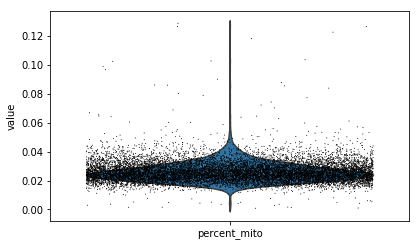

In [20]:
sc.pl.violin(adata, ['percent_mito'],
             jitter=0.4)

After these analyses, we have managed to compute the following metrics for our cells:

In [21]:
adata.obs

,batch,cellular_barcode,n_counts,n_genes,percent_mito
index,,,,,
AGAATAGGTAAAGTCA-1-control,control,AGAATAGGTAAAGTCA-1-control,4038.0,2004,0.085317
TAGACCAGTCGTCTTC-1-control,control,TAGACCAGTCGTCTTC-1-control,4877.0,2036,0.026078
TCCACACTCGGAAACG-1-control,control,TCCACACTCGGAAACG-1-control,4462.0,2042,0.126318
TTTGTCAGTGATAAGT-1-control,control,TTTGTCAGTGATAAGT-1-control,5019.0,2042,0.019354
ACTGAGTAGGTCATCT-1-control,control,ACTGAGTAGGTCATCT-1-control,4535.0,2073,0.096575
TGACTAGGTCCAACTA-1-control,control,TGACTAGGTCCAACTA-1-control,7394.0,2078,0.020864
TGGCCAGGTAAGGATT-1-control,control,TGGCCAGGTAAGGATT-1-control,4792.0,2097,0.026140
GGGATGAAGCAAATCA-1-control,control,GGGATGAAGCAAATCA-1-control,4243.0,2098,0.089965
TAGGCATGTTGGAGGT-1-control,control,TAGGCATGTTGGAGGT-1-control,5079.0,2103,0.063721


## Filtering by ratio of mitochondrial genes and total count

Filter out cells whose mitochondrial gene ratio or total count is too high based on these violin plots.

Scatter plot and matrix before filtering:

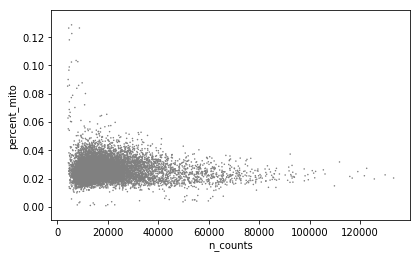

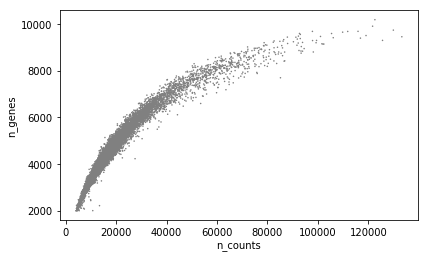

In [22]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [23]:
adata

AnnData object with n_obs × n_vars = 12898 × 16164 
    obs: 'batch', 'cellular_barcode', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_names', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

Remove cells that have total counts >9000 or mitochondrial gene ratio >0.05. These are good numbers per the violin plots above.

In [24]:
adata = adata[adata.obs['n_counts'] < 90000, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Scatter plot, violin plot and matrix after filtering:

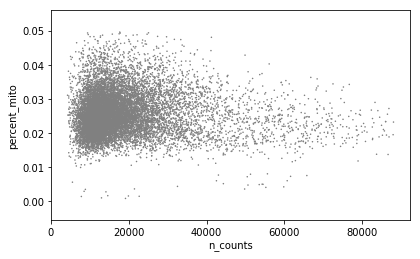

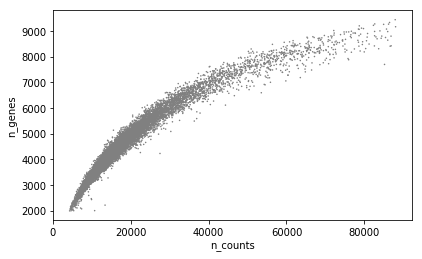

In [25]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

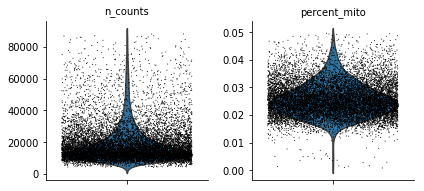

In [26]:
sc.pl.violin(adata, ['n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [27]:
adata

AnnData object with n_obs × n_vars = 12788 × 16164 
    obs: 'batch', 'cellular_barcode', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_names', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

# Normalize total count

Now that we have filtered out outliers, we can normalize the count matrix by total count to reduce this source of variability. We will correct for the library size of the data matrix by rescaling it to 10000 reads per cell. Let us look at the unnormalized counts and perform the normalization:

In [28]:
adata.X.sum(1)

array([ 4870.,  5012.,  7381., ..., 86775., 80753., 77601.], dtype=float32)

In [29]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Let us inspect the new counts:

In [30]:
adata.X.sum(1)

array([10000.   ,  9999.999, 10000.   , ..., 10000.   , 10000.   ,
       10000.   ], dtype=float32)

## Log total counts

Prior knowledge of microarray and bulkRNAseq means we know that a lot of effects are linear in the log of the total count, so it is a good idea to log the data now.

In [31]:
sc.pp.log1p(adata)

In [32]:
adata.X.sum(1)

array([2908.3223, 2901.5002, 2552.1606, ..., 3780.807 , 3988.6646,
       4059.3684], dtype=float32)

## Identifying and filtering highly variable genes.

An important filtering metric is dispersion. Highly variable genes can be identified by this metric and filtered as important for future processing.

In [33]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


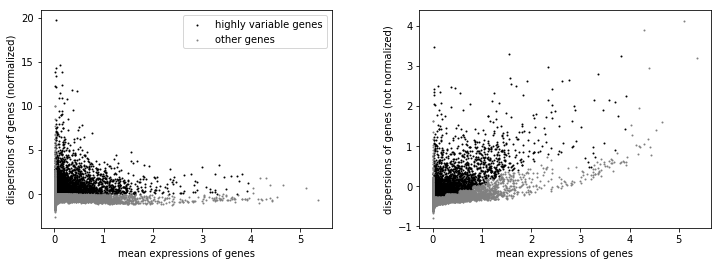

In [34]:
sc.pl.highly_variable_genes(adata)

Number of highly variable genes compared with non-highly variable genes:

In [35]:
collections.Counter(adata.var["highly_variable"])

Counter({False: 11622, True: 4542})

Let's save our genes list before filtering out non highly variable genes and do the actual filtering:

In [36]:
before_highly_variable_genes = list(adata.var["gene_names"])

In [37]:
adata = adata[:, adata.var['highly_variable']]

In [38]:
adata.uns["genes_original"] = original_genes
adata.uns["genes_before_highly_variable"] = before_highly_variable_genes

In [39]:
adata

AnnData object with n_obs × n_vars = 12788 × 4542 
    obs: 'batch', 'cellular_barcode', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_names', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'genes_original', 'genes_before_highly_variable'
    layers: 'ambiguous', 'spliced', 'unspliced'

## Save filtered matrix to file

In [40]:
adata.write(os.path.join("write", "tgfb1-2.h5ad"))